In [ ]:
import torch
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet18_Weights

# Download the dataset

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("emmarex/plantdisease")

# print("Path to dataset files:", path)

## Preprocess the dataset

Mode: RGB
Size: (256, 256)
Format: JPEG


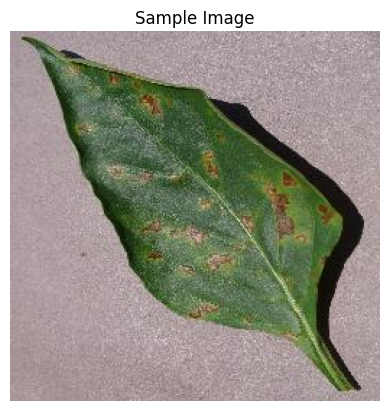

In [18]:
# Path to a class folder in your training data
class_folder = 'dataset_split/train/Pepper__bell___Bacterial_spot'
image_name = os.listdir(class_folder)[0]  # just pick the first image
image_path = os.path.join(class_folder, image_name)

# Open the image using PIL
img = Image.open(image_path)

# Analyze
print(f"Mode: {img.mode}")         # e.g. 'RGB'
print(f"Size: {img.size}")         # e.g. (256, 256)
print(f"Format: {img.format}")     # e.g. 'JPEG'

# Display
plt.imshow(img)
plt.title("Sample Image")
plt.axis("off")
plt.show()

In [19]:
transform = transforms.Compose([
    transforms.Resize(256),               # Resize smaller edge to 256
    transforms.CenterCrop(224),           # Crop 224x224 square from center
    transforms.ToTensor(),                # Convert PIL image to tensor (C x H x W), values [0,1]
    transforms.Normalize(                 # Normalize with ImageNet mean/std
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

In [20]:
# store the data in tensors
training_dataset = ImageFolder(root="dataset_split/train", transform=transform)

In [21]:
train_loader = DataLoader(
    training_dataset,
    batch_size=32,      # You can tune this
    shuffle=True,       # Shuffle for training
    num_workers=2       # Optional: use 2 subprocesses to load data
)

In [ ]:
# Load pretrained ResNet18
default_weights = ResNet18_Weights.DEFAULT
model = models.resnet18(weights=default_weights)

# Freeze all layers (feature extractor part)
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer
num_classes = 15  # your case
model.fc = nn.Linear(model.fc.in_features, num_classes)


/home/kheyal/dev/plant_desease_classifier/.pdc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kheyal/dev/plant_desease_classifier/.pdc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # only train final layer

In [24]:
device = torch.device('cpu')  # or 'cuda' if available in future
model = model.to(device)

In [25]:
val_dataset = ImageFolder(root="dataset_split/val", transform=transform)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

In [26]:
num_epochs = 7

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # ---------- Training ----------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  # batch loss * batch size
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total * 100

    # ---------- Validation ----------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / total
    val_acc = correct / total * 100

    # ---------- Output ----------
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")



Epoch 1/7
------------------------------
Train Loss: 0.8340 | Train Acc: 77.91%
Val   Loss: 0.4233 | Val   Acc: 88.66%

Epoch 2/7
------------------------------
Train Loss: 0.3813 | Train Acc: 89.40%
Val   Loss: 0.3181 | Val   Acc: 91.07%

Epoch 3/7
------------------------------
Train Loss: 0.3049 | Train Acc: 90.89%
Val   Loss: 0.2832 | Val   Acc: 91.78%

Epoch 4/7
------------------------------
Train Loss: 0.2702 | Train Acc: 91.66%
Val   Loss: 0.2494 | Val   Acc: 92.60%

Epoch 5/7
------------------------------
Train Loss: 0.2478 | Train Acc: 92.25%
Val   Loss: 0.2444 | Val   Acc: 92.36%

Epoch 6/7
------------------------------
Train Loss: 0.2319 | Train Acc: 92.98%
Val   Loss: 0.2407 | Val   Acc: 92.40%

Epoch 7/7
------------------------------
Train Loss: 0.2204 | Train Acc: 92.94%
Val   Loss: 0.2446 | Val   Acc: 92.19%


In [27]:
# Save the model (only the weights)
torch.save(model.state_dict(), "plant_model.pth")

# Prediction Phase